In [283]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script rec.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [284]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])
# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# ndist = int(sys.argv[7])
# st =  int(sys.argv[8])
# same_probe =  sys.argv[9]=='True'
# flg_show = False

cp.cuda.Device(0).use()
ntheta = 100  # number of angles (rotations)
ptheta = 100  # holography chunk size for GPU processing
binning = 3
niter = 33
iter_step = 8
ndist = 4
st = 0
same_probe = True
flg_show = True

cropx_left = 0
cropx_right = 0
cropy_up = 0
cropy_down = 0

# cropx_left = 256
# cropx_right = 256
# cropy_up = 256
# cropy_down = 256

n = (2048-cropx_left-cropx_right)//2**binning

ne = 3328//2**binning
print(n)
pn = 32  # tomography chunk size for GPU processing

center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3.0e-6
energy = 33.35 #[keV] xray energy
focusToDetectorDistance = 1.25 # [m]
sx0 = 0#-2.493e-3
z1 = np.array([13.23e-3,13.7745e-3,15.9435e-3,20.448e-3])[:ndist]-sx0
z1 = np.array([12.5171e-3,13.0487e-3,15.1693e-3, 19.5499e-3])[:ndist]-sx0
# 12.5171,13.0487,15.1693, 19.5499
# z1[0] = 13.0487e-3
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size
print(f'{voxelsize=}')
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2


256
voxelsize=2.4032832000000003e-07


In [285]:
norm_magnifications*ne/n

array([1.625     , 1.558798  , 1.34088504, 1.04042923])

## Read data

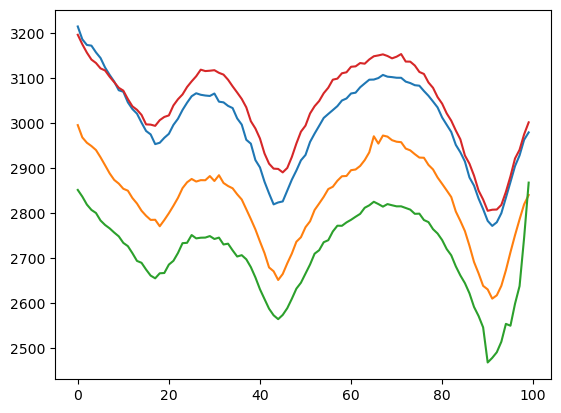

[5660.94   5169.925  4980.787  5600.4707]
[5193.3643 4995.069  4769.925  5337.807 ]
[5660.94   5660.941  5660.9404 5660.94  ]


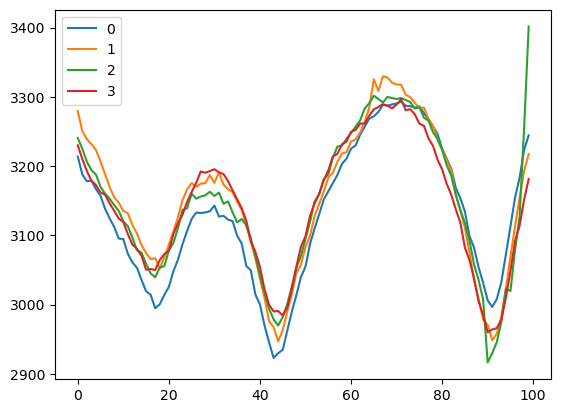

In [286]:
data00 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref00 = np.zeros([ndist,n,n],dtype='float32')
ref01 = np.zeros([ndist,n,n],dtype='float32')
dark00 = np.zeros([ndist,n,n],dtype='float32')

mmeans = np.zeros(8)
for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=st+j*1500//ntheta
        fname = f'/data/viktor/id16a/brain/X2O2_WM_contShift_030nm_a_{k+1}_/X2O2_WM_contShift_030nm_a_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data00[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/brain/X2O2_WM_contShift_030nm_a_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref00[k] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/brain/X2O2_WM_contShift_030nm_a_{k+1}_/refHST2000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref01[k] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/brain/X2O2_WM_contShift_030nm_a_{k+1}_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    dark00[k] = tmp



data00 -= dark00[:,np.newaxis]
ref00 -= dark00
ref01 -= dark00

for k in range(4):
    plt.plot(np.mean(data00[k],axis=(1,2)))
plt.show()

ref01[2]*=0.85
# ref01[0]*=0.9
# ref00[0]*=0.985
print(np.mean(ref00,axis=(1,2)))
print(np.mean(ref01,axis=(1,2)))
for k in range(ndist):
    v = np.linspace(np.mean(ref00[k]),np.mean(ref01[k]),2000)[st:2000:2000//ntheta]/np.mean(ref00[k])
    data00[k]/=v[:,np.newaxis,np.newaxis]
    data00[k]*=np.mean(ref00[0])/np.mean(ref00[k])
for k in range(ndist):
    ref00[k]*=np.mean(ref00[0])/np.mean(ref00[k])

print(np.mean(ref00,axis=(1,2)))
for k in range(4):
    plt.plot(np.mean(data00[k],axis=(1,2)),label=f'{k}')
plt.legend()
plt.show()
# mean_all = np.mean(data00[:,:,0:n//16,0:n//16])
# mean_each = np.mean(data00[:,:,0:n//16,0:n//16],axis=(2,3))
# data00 = data00*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

# ref00_mean = np.mean(ref00[:,0:n//16,0:n//16],axis=(1,2))
# ref00 = ref00*mean_all/ref00_mean[:,np.newaxis,np.newaxis]


# print(np.mean(data00,axis=(1,2)))
ref00[:] = np.mean(ref00,axis=0)
# ref00[:] = ref00[1]#np.mean(ref00,axis=0)[np.newaxis]



In [287]:
# for k in range(4):
#     tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
#     tmp1 = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST1500.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#     im=axs[0].imshow(tmp,cmap='gray')
#     fig.colorbar(im)
#     im=axs[1].imshow(tmp1,cmap='gray')#,vmin=-500,vmax=500)
#     fig.colorbar(im)
#     im=axs[2].imshow(tmp1-tmp,cmap='gray')#,vmin=-500,vmax=500)
#     fig.colorbar(im)
    

# Dark-flat field correction

In [288]:

data0 = data00.copy()
ref0 = ref00.copy()
ref0[ref0<0] = 0
data0[data0<0]=0
rdata=data0/(ref0[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/c{k}.tiff',overwrite=True)
    dxchange.write_tiff(data0[k],f'/data/viktor/tmp/n{k}.tiff',overwrite=True)


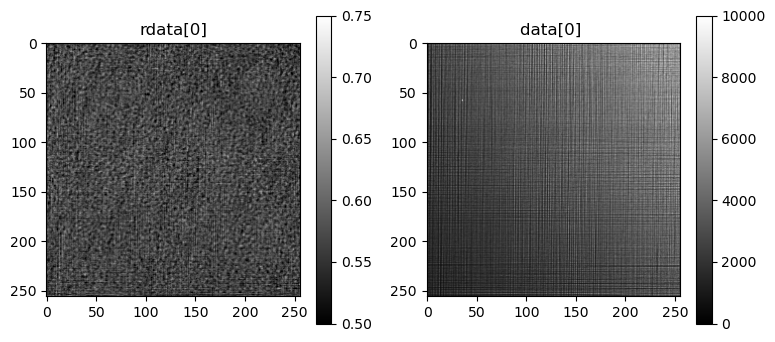

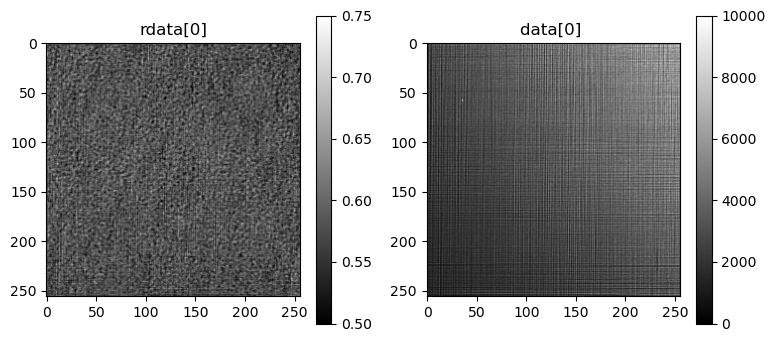

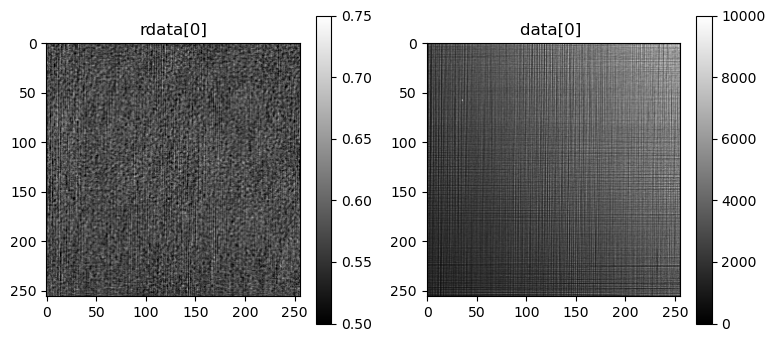

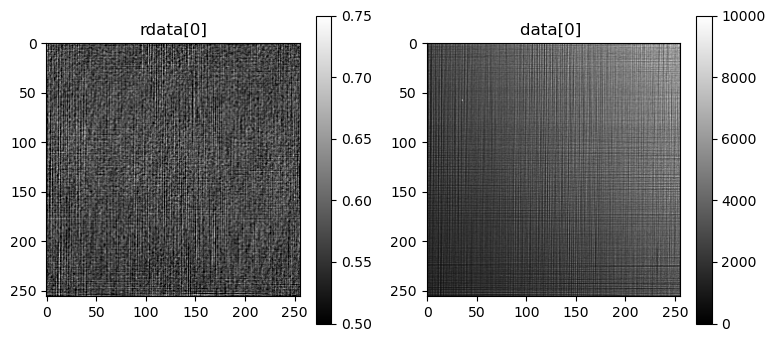

In [289]:
if flg_show:

    for k in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(rdata[k,0],cmap='gray',vmax=0.75,vmin=0.5)
        axs[0].set_title('rdata[0]')
        fig.colorbar(im)
        im=axs[1].imshow(data0[k,0],cmap='gray',vmin=0,vmax=10000)
        axs[1].set_title('data[0] ')
        fig.colorbar(im)

# use second ref
# ref0[:] = ref0[1:2]#np.mean(ref0,axis=0)[np.newaxis]
# rdata=data0/(ref0[:,np.newaxis]+1e-9)


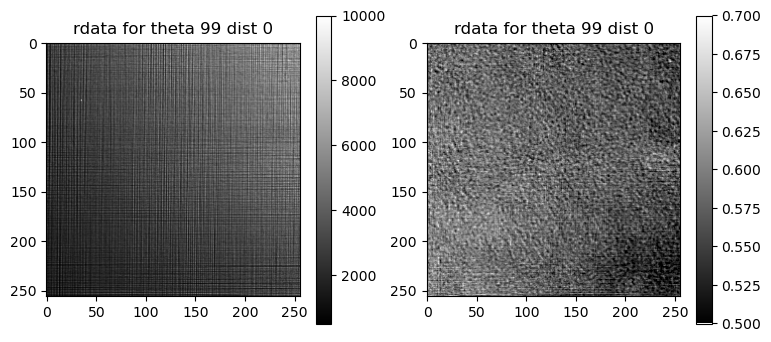

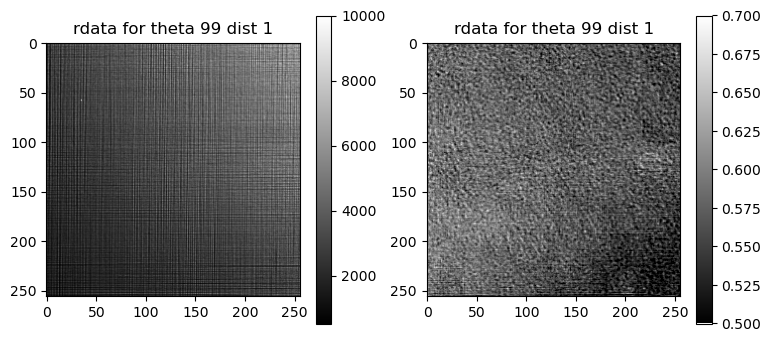

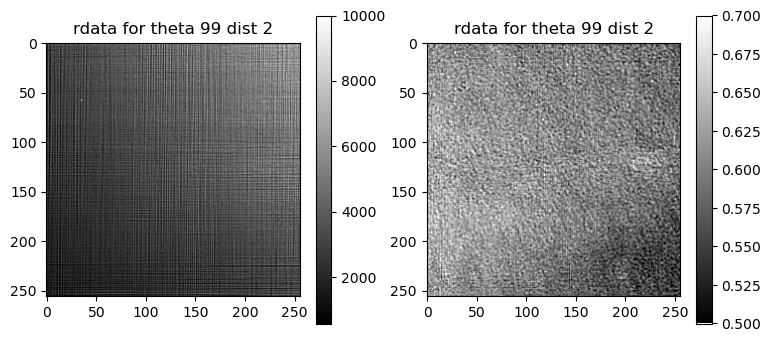

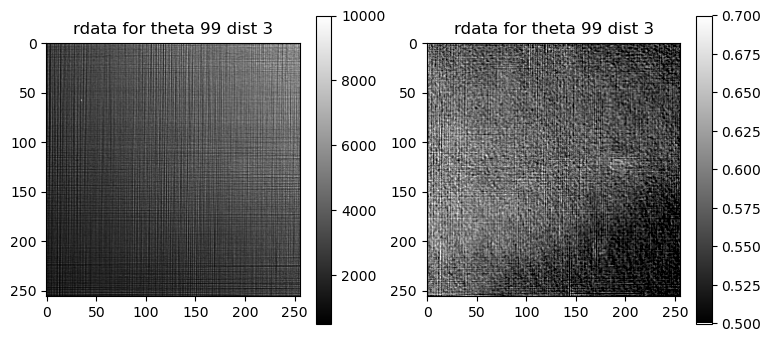

In [290]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(data00[k,-1],cmap='gray',vmax=10000)#,vmin = 0.5,vmax=2 )
        axs[0].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray',vmin = 0.5,vmax=0.7)
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

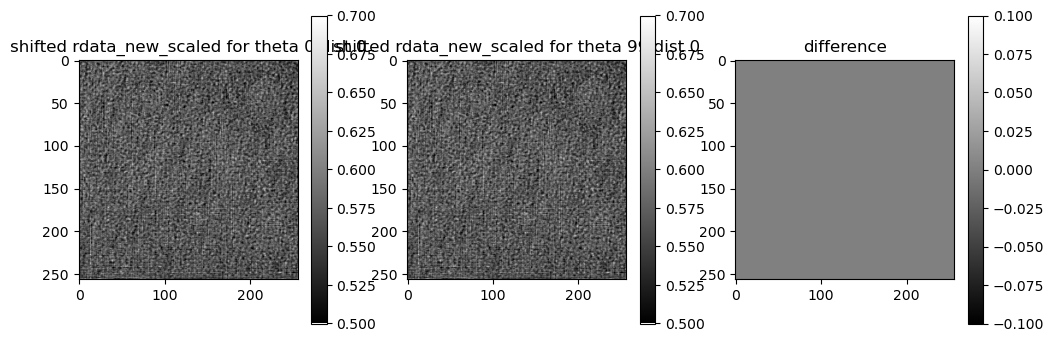

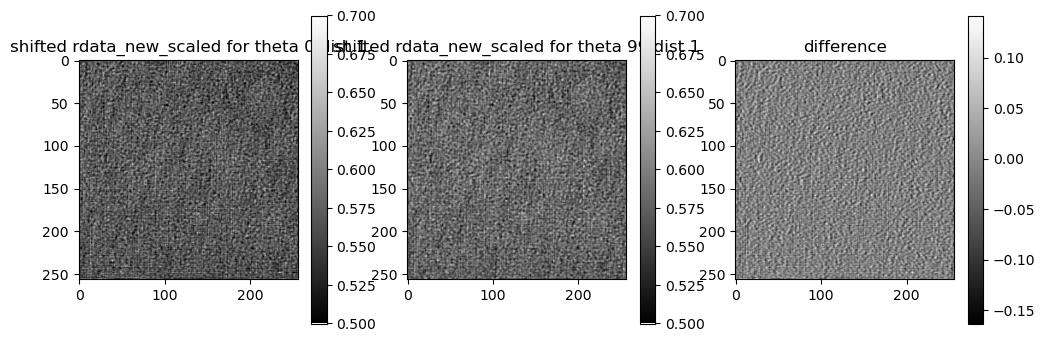

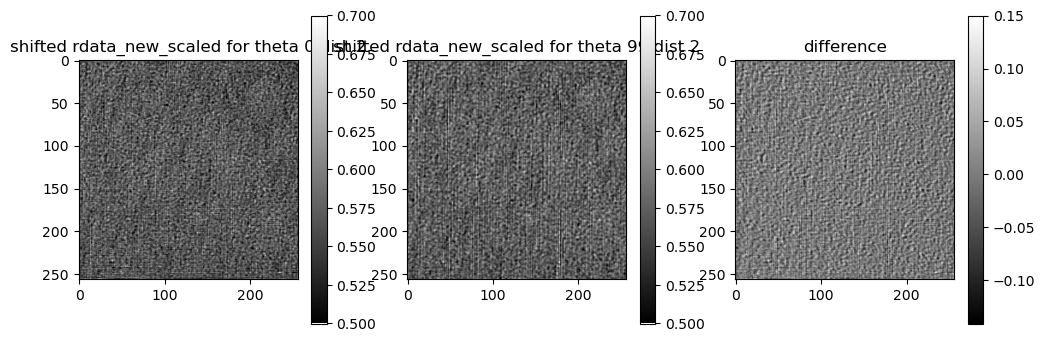

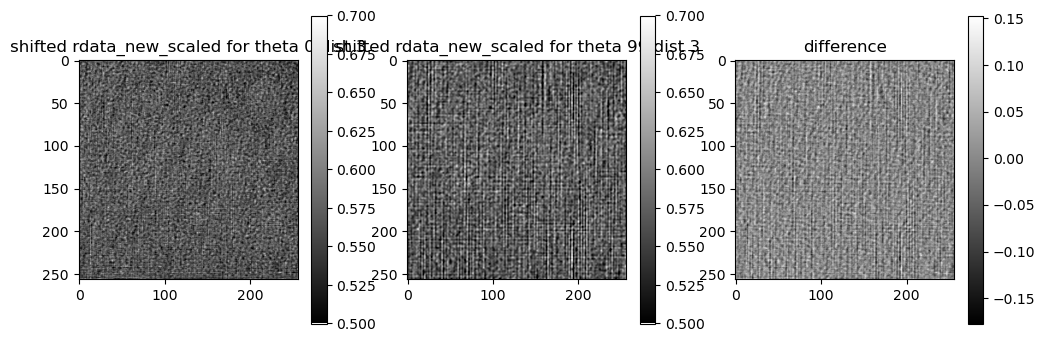

In [291]:
rdata_scaled = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = ndimage.zoom(rdata[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.5,vmax=0.7 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.5,vmax=0.7 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled[0,0]-rdata_scaled[k,0],cmap='gray')#,vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)        

In [292]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_random = np.zeros([ndist,ntheta,2],dtype='float32')
# for k in range(ndist):
#     s = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/correct.txt').astype('float32')[st:2000:2000//ntheta]/norm_magnifications[k]    
#     shifts_random[k,:,0] = s[:,1]+(1024-(2048+cropy_up-cropy_down)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
#     shifts_random[k,:,1] = s[:,0]+(1024-(2048+cropx_left-cropx_right)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]

# shifts_correct3D =np.zeros([ntheta,2],dtype='float32')
# s = np.loadtxt(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/correct_correct3D.txt').astype('float32')[st:1500:1500//ntheta]
# shifts_correct3D[:,0] = s[:,1]
# shifts_correct3D[:,1] = s[:,0]

# shifts_random+=shifts_correct3D
shifts_dist = np.zeros([ndist,ntheta,2],dtype='float32')
rdata_scaled_tmp=rdata_scaled.copy()
for j in range(ntheta):
    for k in range(0,ndist):#!!!!!!!!!!!!!!
        a = apply_shift(rdata_scaled[k,j:j+1],-shifts_random[k,j:j+1]/2**binning)# note first shift then magnification    
        rdata_scaled_tmp[k,j:j+1] = a    
        shifts_dist[k,j] = registration_shift(a,rdata_scaled_tmp[0,j:j+1],upsample_factor=10)
        print(f'{k} {j}: {shifts_random[k,j:j+1]/2**binning} {shifts_dist[k,j]}')
# raise Exception


0 0: [[0. 0.]] [0. 0.]
1 0: [[0. 0.]] [-0.5 -3.1]
2 0: [[0. 0.]] [1.6 3.1]
3 0: [[0. 0.]] [ 1.9 -4.6]
0 1: [[0. 0.]] [0. 0.]
1 1: [[0. 0.]] [-0.5 -3.1]
2 1: [[0. 0.]] [1.6 3.1]
3 1: [[0. 0.]] [ 1.8 -4.5]
0 2: [[0. 0.]] [0. 0.]
1 2: [[0. 0.]] [-0.5 -3.1]
2 2: [[0. 0.]] [1.6 3.1]
3 2: [[0. 0.]] [ 1.8 -4.7]
0 3: [[0. 0.]] [0. 0.]
1 3: [[0. 0.]] [-0.5 -3.1]
2 3: [[0. 0.]] [1.6 3.1]
3 3: [[0. 0.]] [ 1.8 -4.6]
0 4: [[0. 0.]] [0. 0.]
1 4: [[0. 0.]] [-0.5 -3.1]
2 4: [[0. 0.]] [1.6 3.1]
3 4: [[0. 0.]] [ 1.9 -4.6]
0 5: [[0. 0.]] [0. 0.]
1 5: [[0. 0.]] [-0.5 -3.2]
2 5: [[0. 0.]] [1.6 3.1]
3 5: [[0. 0.]] [ 1.8 -4.6]
0 6: [[0. 0.]] [0. 0.]
1 6: [[0. 0.]] [-0.5 -3.2]
2 6: [[0. 0.]] [1.6 3. ]
3 6: [[0. 0.]] [ 1.8 -4.5]
0 7: [[0. 0.]] [0. 0.]
1 7: [[0. 0.]] [-0.5 -3.2]
2 7: [[0. 0.]] [1.6 3. ]
3 7: [[0. 0.]] [ 1.8 -4.6]
0 8: [[0. 0.]] [0. 0.]
1 8: [[0. 0.]] [-0.5 -3.2]
2 8: [[0. 0.]] [1.6 3. ]
3 8: [[0. 0.]] [ 1.8 -4.6]
0 9: [[0. 0.]] [0. 0.]
1 9: [[0. 0.]] [-0.5 -3.2]
2 9: [[0. 0.]] [1.7 3. ]
3 9: [[

In [293]:
# dxchange.write_tiff(rdata_scaled_tmp[0],'/data/viktor/holo/tmp0.tiff',overwrite=True)
# dxchange.write_tiff(rdata_scaled_tmp[1],'/data/viktor/holo/tmp1.tiff',overwrite=True)
# dxchange.write_tiff(rdata_scaled_tmp[2],'/data/viktor/holo/tmp2.tiff',overwrite=True)
# dxchange.write_tiff(rdata_scaled_tmp[3],'/data/viktor/holo/tmp3.tiff',overwrite=True)


In [294]:
            
# from ipywidgets import interact
# import ipywidgets as widgets
# if flg_show:
#     def plot_projections(sid=1):
#         plt.imshow(np.abs(rdata_scaled_tmp[2,sid]),cmap='gray',vmin=0.5,vmax=2)
#         # plt.colorbar()
#     interact(plot_projections, sid = widgets.IntSlider(value=0,
#                                                 min=0,
#                                                 max=rdata.shape[1]-1,
#                                                 step=1))

    

# Total shifts in pixels before normalized scaling

In [295]:

# import scipy.io 
# shifts_new = -scipy.io.loadmat('/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_/rhapp_py.mat')['rhapp'][:,:,st:1500:1500//ntheta].swapaxes(0,2).swapaxes(0,1)[:ndist]

# print(shifts_new)
# shifts_new+=shifts_random
# shifts_new/=2**binning


shifts = (shifts_dist+shifts_random/2**binning)#*norm_magnifications[:,np.newaxis,np.newaxis]# cannot be combined with 

# if flg_show:
#     for k in range(ndist):
#         plt.figure()
#         plt.plot(shifts[k,:,1],'rx')
#         plt.plot(shifts_new[k,:,1],'bo')

# take shifts from Peter
# shifts = shifts_new


# TEST: Scale initial data to 1 magnification and apply all shifts

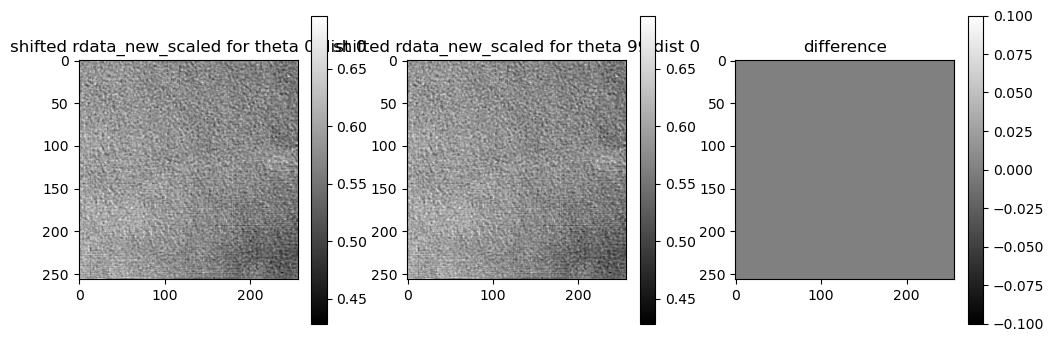

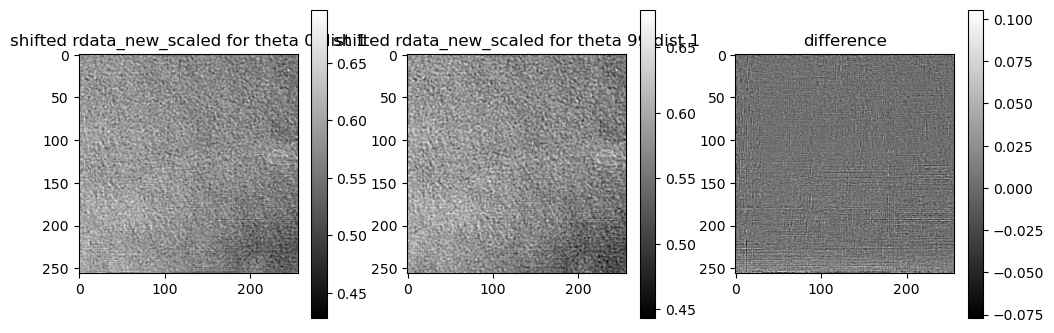

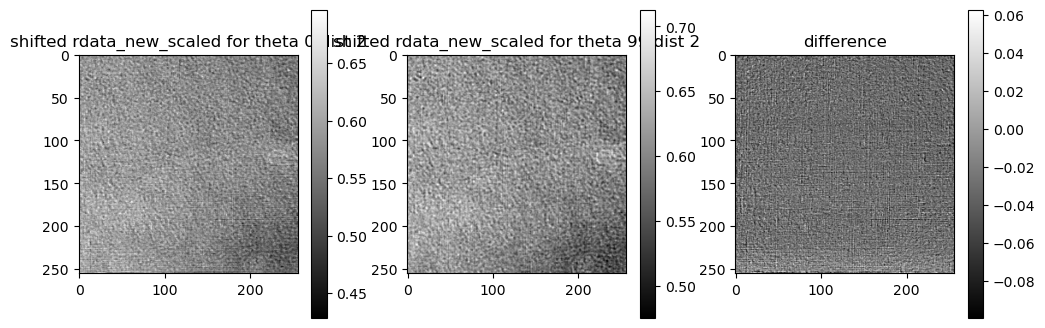

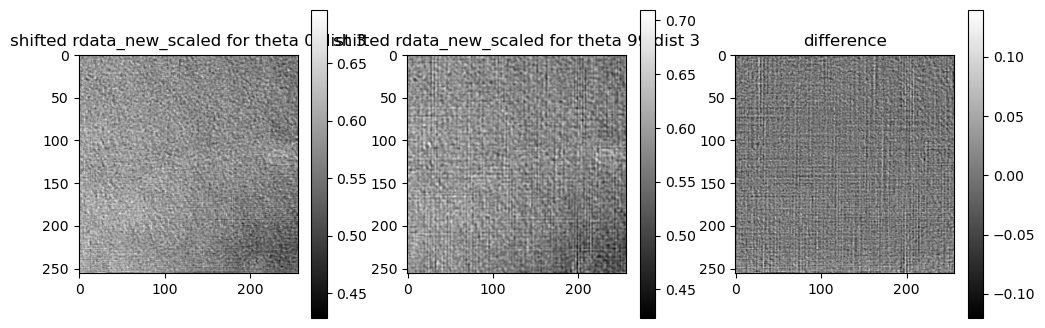

In [296]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled_new[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]  

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,-1],cmap='gray')
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,-1],cmap='gray')
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,-1]-rdata_scaled_new[k,-1],cmap='gray')
        axs[2].set_title(f'difference')
        fig.colorbar(im)          
    

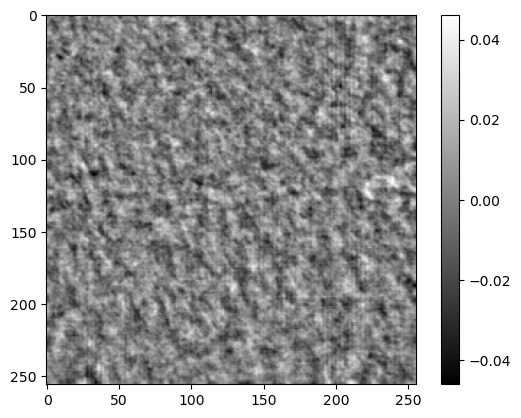

In [297]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase


distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(ne,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recCTFPurePhase = np.zeros([ntheta,ne,ne],dtype='complex64')
for k in range(ntheta):
    rads = np.pad(rdata_scaled_new[:ndist,k],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')
    recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-2))
if flg_show:
    recCTFPurePhase = recCTFPurePhase[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
    plt.imshow(np.angle(recCTFPurePhase[-1]),cmap='gray')
    plt.colorbar()
dxchange.write_tiff(np.angle(recCTFPurePhase),f'/data/vnikitin/holo/brain/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/CTF.tiff',overwrite=True)



## Create a solver class for holography

In [298]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications,distances2,same_probe=same_probe)


note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [299]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
shifts_ref = shifts[:]
print(arr1.shape,prb1.shape,shifts_ref.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(100, 416, 416) (4, 256, 256) (4, 100, 2)
(5.899094e+22+809212640000000j)
(5.8990918e+22-83930230000j)
(5.899092e+22+2002863500000000j)


In [300]:
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2 + \||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_r}\|_2^2\to \text{min}_{\psi_i,q}$ 

In [301]:

from holotomo.utils import chunk
def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None

    if code is not None:
        code_gpu = cp.array(code)   
    for ids in chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        for ids in chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(cp.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

import time

def cg_holo_batch2(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts)          
            # d = -pslv.adj_holo_batch(fpsi-data*np.exp(1j*(np.angle(fpsi))), prb,shifts)/np.max(np.abs(prb))**2
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts)/np.max(np.abs(prb))**2
                       
            # line search
            fd = pslv.fwd_holo_batch(d, prb,shifts)                 
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil)
            
            # dprb = -pslv.adj_holo_prb_batch(fprb-data*np.exp(1j*np.angle(fprb)),psi,shifts)#/ndist**2
            # dprb -= pslv0.adj_holo_prb_batch(fprb0-data_ref*np.exp(1j*np.angle(fprb0)),psi_nil,shifts_nil)
            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil)
            dprb *= 1/((pslv.ntheta+1))
            

            # line search
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)
    
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(np.angle(psi[0,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/holo/brain/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/holo/brain/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            
    return psi,prb


In [302]:

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    shifts = cp.array(shifts)
    psi_nil = psi[:1]*0+1
    shifts_nil = shifts[:,:1]*0
    conv=np.zeros(piter)
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts)          
            # d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            grad = pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
            
            #d = -grad
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            fd = pslv.fwd_holo(d, prb,shifts)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
      
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil)
            gradprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts)
            gradprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil)
            gradprb*=1/(pslv.ntheta+1)
            
            #dprb = -gradprb
             # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb
            # dprb -= pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts_nil)
            
            gammaprb = line_search(minf,gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts_nil)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
            conv[i]=err
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(cp.abs(psi[0,:,:]).get(),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0,:,:]).get(),cmap='gray')
                # im=axs[1].imshow(cp.angle(psi[0,:,:]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/brain/r_{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/brain/r_{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb,conv

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.ne, pslv.ne], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                

    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu,conv = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb,conv


0) gammapsi=0.5 gammaprb=1, err=7.74347e-02


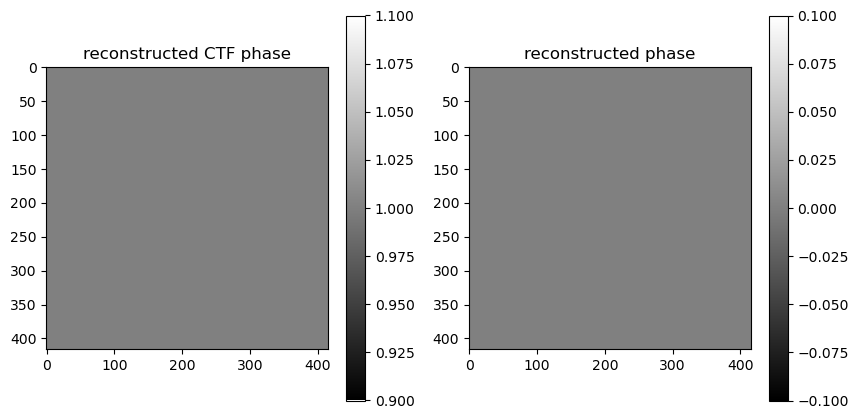

1) gammapsi=0.5 gammaprb=1, err=4.12276e-02
2) gammapsi=0.5 gammaprb=1, err=4.10337e-02
3) gammapsi=0.5 gammaprb=1, err=4.14466e-02
4) gammapsi=0.5 gammaprb=1, err=4.10272e-02
5) gammapsi=0.5 gammaprb=1, err=4.07651e-02
6) gammapsi=0.5 gammaprb=0.5, err=4.09529e-02
7) gammapsi=0.5 gammaprb=0.5, err=4.10990e-02
8) gammapsi=0.5 gammaprb=0.5, err=4.13294e-02
9) gammapsi=0.5 gammaprb=0.5, err=4.10329e-02
10) gammapsi=0.5 gammaprb=0.25, err=4.16747e-02
11) gammapsi=0.5 gammaprb=0.25, err=4.17799e-02
12) gammapsi=0.5 gammaprb=0.25, err=4.12788e-02
13) gammapsi=0.5 gammaprb=0.25, err=4.13017e-02
14) gammapsi=0.5 gammaprb=0.5, err=4.20371e-02
15) gammapsi=0.5 gammaprb=0.25, err=4.12202e-02
16) gammapsi=0.5 gammaprb=0.25, err=4.13382e-02
17) gammapsi=0.5 gammaprb=0.5, err=4.13257e-02
18) gammapsi=0.5 gammaprb=0.25, err=4.11854e-02
19) gammapsi=0.5 gammaprb=0.125, err=4.10090e-02
20) gammapsi=0.5 gammaprb=0.25, err=4.15515e-02
21) gammapsi=0.5 gammaprb=0.125, err=4.10377e-02
22) gammapsi=0.5 gam

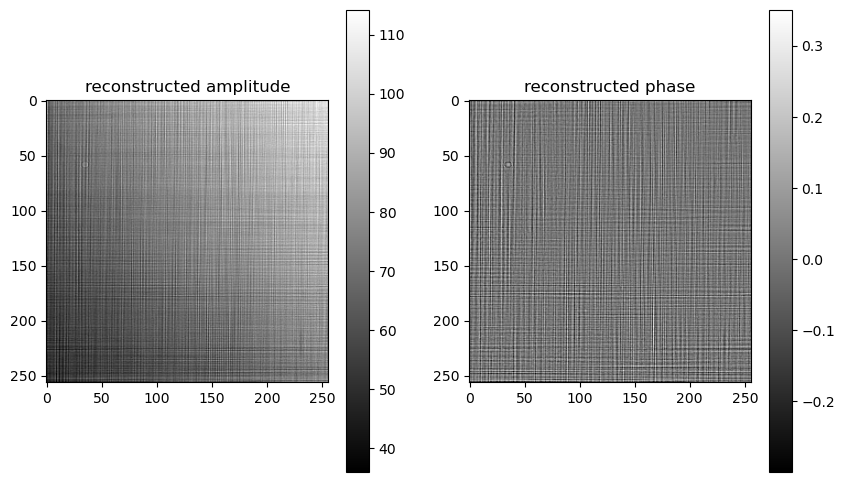

In [303]:

pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 


rec = np.ones([1,ne,ne],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = np.sqrt(ref0[:,np.newaxis])
shifts_ref = np.array(shifts)[:,:1]*0
_,rec_prb0,conv = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 33, shifts_ref, False,True,1,33,0.5,1)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)

0) gammapsi=1 gammaprb=2, err=2.33496e+07


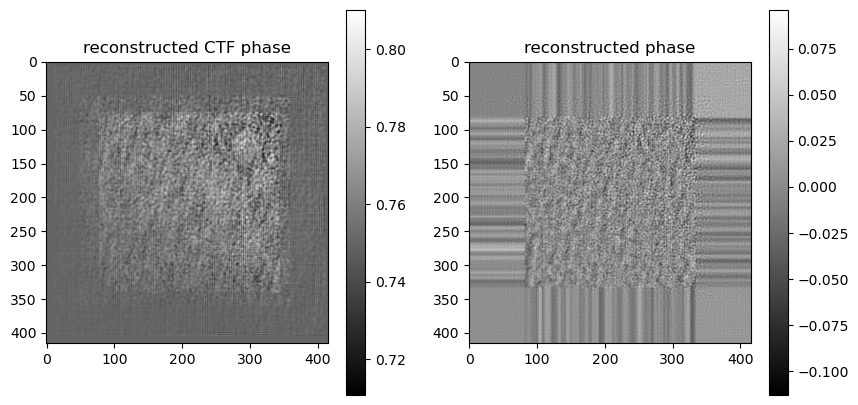

16) gammapsi=0.5 gammaprb=0.125, err=4.37356e+06


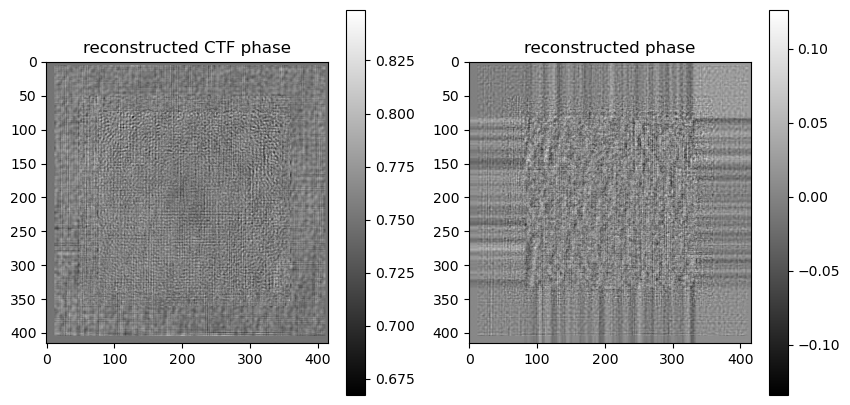

32) gammapsi=0.5 gammaprb=0.5, err=3.76451e+06


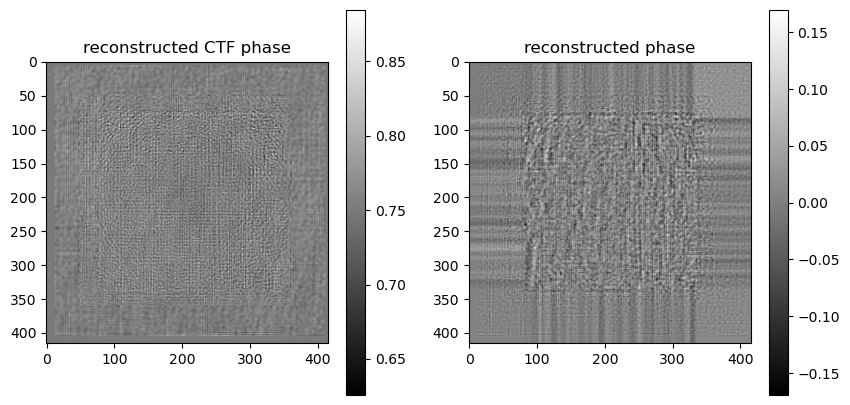

48) gammapsi=0.25 gammaprb=0.5, err=3.55809e+06


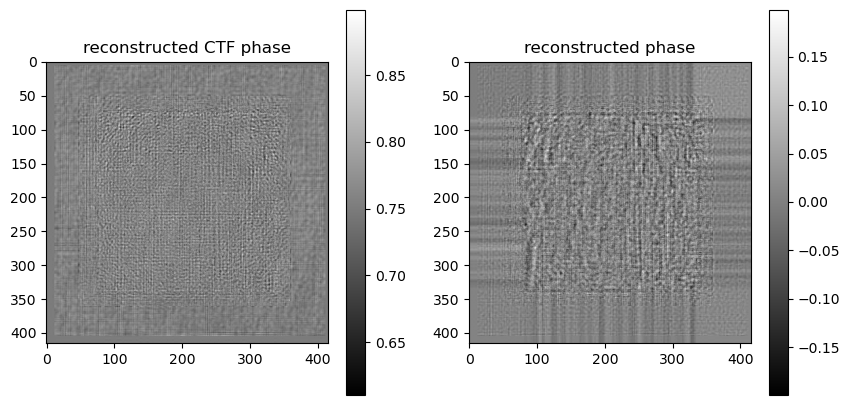

64) gammapsi=0.125 gammaprb=1.0, err=3.46152e+06


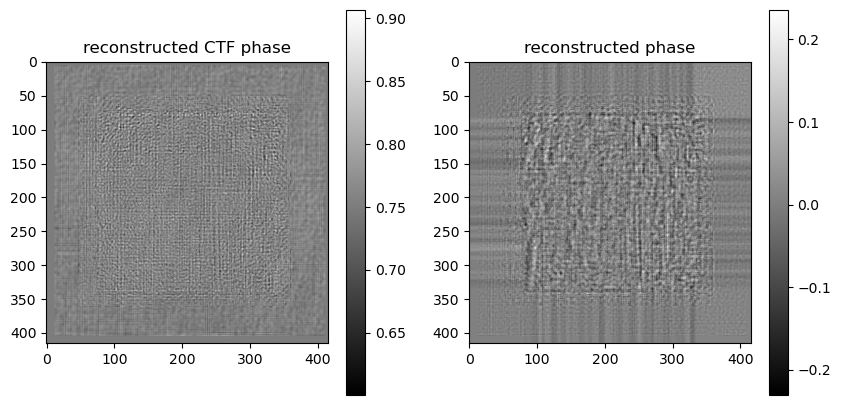

80) gammapsi=0.125 gammaprb=1.0, err=3.38464e+06


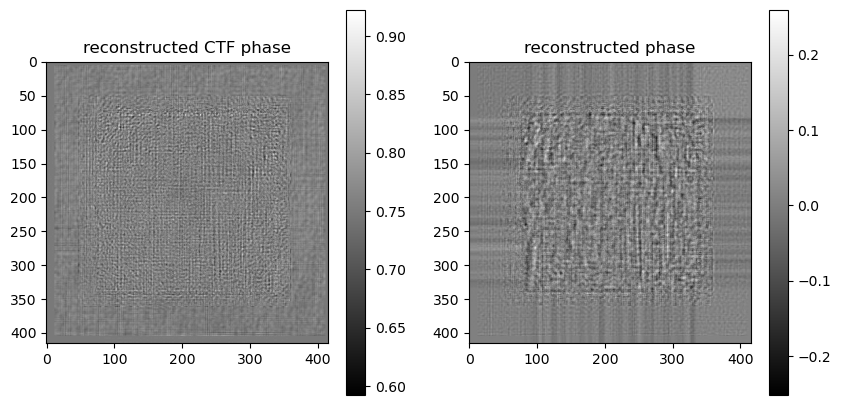

KeyboardInterrupt: 

In [310]:


shifts_rec = np.array(shifts)
rec = np.ones([ntheta,pslv.ne,pslv.ne],dtype='complex64')*1
rec = np.pad(recCTFPurePhase,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')*0.75
# use only the abs value of the probe as initial guess
rec_prb[:] = rec_prb0

data_ref = np.sqrt(ref0[:,np.newaxis])
data_rec = np.sqrt(data0)

# data_rec=data_rec/data_ref
# data_ref[:] = 1
# rec_prb[:] = 1
rec,rec_prb,conv = cg_holo_batch(pslv, pslv0, data_rec, data_ref, rec, rec_prb, 10001, shifts_rec, True,True,128,128, 1,2)

In [ ]:
plt.imshow(np.abs(rec_prb[0,:,:]),cmap='gray')
plt.show()
plt.imshow(np.angle(rec_prb[1,n//2-128+32:n//2+128+32,n//2-128:n//2+128]),cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
for k in range(len(distances)):
    dxchange.write_tiff(np.abs(rec_prb[k,n//2-128+32:n//2+128+32,n//2-128:n//2+128]),f'../3d_ald_syn/data/prb_syn_abs_{256}_{k}',overwrite=True)
    dxchange.write_tiff(np.angle(rec_prb[k,n//2-128+32:n//2+128+32,n//2-128:n//2+128]),f'../3d_ald_syn/data/prb_syn_angle_{256}_{k}',overwrite=True)